In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
from PIL import Image
import os

In [2]:
def openH5(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        # Get the data
        header = list(f.keys())
        classes = f[header[0]]
        x = f[header[1]]
        y = f[header[2]]
        classes = np.array(classes)
        x = np.array(x)
        y = np.array(y)
        f.close()
    return classes, header, x, y

In [3]:
test_classes, test_header, test_set_x, test_set_y = openH5("test_catvnoncat.h5")
train_classes, train_header, train_set_x, train_set_y = openH5("train_catvnoncat.h5")

Keys: <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>
Keys: <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


y = 1, it's a 'cat' picture.
total number of train_set_x: 209
total number of train_set_y: 209


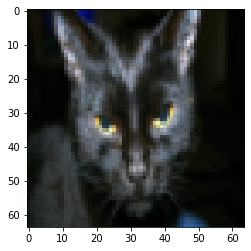

In [4]:
index = 25
np.random.seed(1)
plt.imshow(train_set_x[index])
print("y = " + str(train_set_y[index]) + ", it's a '" + train_classes[np.squeeze(train_set_y[index])].decode(
    "utf-8") + "' picture.")
print("total number of " + str(train_header[1]) + ": " + str(train_set_x.shape[0]))
print("total number of " + str(train_header[2]) + ": " + str(train_set_y.shape[0]))

In [5]:
train_set_y = train_set_y.reshape(-1,1).T
test_set_y = test_set_y.reshape(-1,1).T

In [6]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [7]:
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0],-1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0],-1).T

In [8]:
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [9]:
### CONSTANTS DEFINING THE MODEL ####
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [10]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [11]:
def initialize_parameters_deep(layer_dims, sed=3):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    sed -- random.seed variable (default is 3)
    """
    
    np.random.seed(sed)
    parameters = {}
    L = layers_dims[3]-1 + 1 # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.1
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [12]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [14]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)],
                                            parameters['b' + str(l)], activation='relu')
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], 
                                          parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    
    return AL, caches

In [15]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = -1 / m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL)))
    
    cost = np.squeeze(cost)
    
    return cost

In [16]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    return dA_prev, dW, db

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [18]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] =dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [19]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """

    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l+1)]
    return parameters

In [75]:

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        
        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [74]:
def relu(x):
    return x * (x > 0), x

In [22]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s, z

In [23]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

In [24]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [25]:
X = train_x
parameters = initialize_parameters(n_x, n_h, n_y)
W1 = parameters["W1"]
b1 = parameters["b1"]
Z, linear_cache = linear_forward(X, W1, b1)
A, activation_cache = sigmoid(Z)

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130197
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.1744831811255664
Cost after iteration 1600: 0.17080762978095304
Cost after iteration 1700: 0.11306524562164758
Cost after iteration 1800: 0.09629426845937161
Cost after iteration 1900: 0.08342617959726858
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.066307481

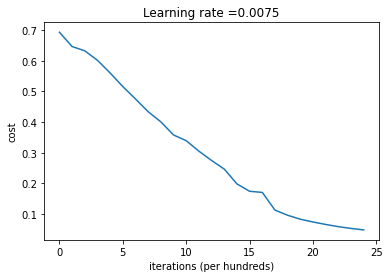

In [76]:
parameters, costs = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [79]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    Z1 = np.dot(W1, X) + b1
    A1, XX = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2, XX = sigmoid(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [90]:
def predict(X, Y, parameters):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    if len(parameters)>4:
        A, cache = L_model_forward(X, parameters)
    else:
        A, cache = forward_propagation(X, parameters)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    print(Y_prediction)
    accuracy = float((np.dot(Y,Y_prediction.T) + np.dot(1 - Y, 1 - Y_prediction.T)) / float(Y.size)*100)
    print ("Accuracy: {} %".format(accuracy))
    return Y_prediction

In [81]:
predictions_train = predict(train_x, train_set_y, parameters)

parameters length 4
Accuracy: 100.0 %


In [82]:
predictions_test = predict(test_x, test_set_y, parameters)

parameters length 4
Accuracy: 72.0 %


In [32]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [33]:
def save_param(iteration, cost, parameters, layers_dims):
    data = [iteration, cost]
    np.savetxt('cost.txt', data, delimiter=',')
    L = layers_dims[3]-1+1
    for l in range(1, L):
        np.savetxt(f"fileW{l}.txt", parameters[f"W{l}"], delimiter=',')
        np.savetxt(f"fileB{l}.txt", parameters[f"b{l}"], delimiter=',')

In [47]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    grads = {}
    start_i = 0
    L = layers_dims[3]-1+1
    # num_iterations = 2500 # modify iterations (default is 2500)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Load W and b parameters if the files are there
    if os.path.isfile("cost.txt"):
        data = np.loadtxt("cost.txt", delimiter=',')
        num_iterations += int(data[0])
        start_i = int(data[0]) - 1
        print(f"Loaded last parameters with cost of {data[1]} and {int(data[0])} iteration")
    for l in range(1, L):
        if os.path.isfile(f"fileW{l}.txt"):
            parameters['W' + str(l)] = np.loadtxt(f"fileW{l}.txt", delimiter=',')
            if l==4:
                parameters['W' + str(l)] = np.reshape(parameters['W' + str(l)], (-1, 1)).T
        if os.path.isfile(f"fileB{l}.txt"):
            parameters['b' + str(l)] = np.loadtxt(f"fileB{l}.txt", delimiter=',')
            parameters['b' + str(l)] = np.reshape(parameters['b' + str(l)], (-1, 1))
        
    for i in range(start_i, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    save_param(num_iterations, cost, parameters, layers_dims)
    print("saved parameters.")

    return parameters, costs

In [83]:
# change the iterations here.
parameters, costs = L_layer_model(train_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

Loaded last parameters with cost of 0.02036179849184959 and 22500 iteration
Cost after iteration 22500: 0.020351041946691305
Cost after iteration 22600: 0.02018324521919703
Cost after iteration 22700: 0.019914909568920048
Cost after iteration 22800: 0.019708493328333
Cost after iteration 22900: 0.019501631580408036
Cost after iteration 23000: 0.019295821641221
Cost after iteration 23100: 0.019106857668133654
Cost after iteration 23200: 0.018898500273811934
Cost after iteration 23300: 0.018749729814797163
Cost after iteration 23400: 0.01852823756751555
Cost after iteration 23500: 0.01833211239397312
Cost after iteration 23600: 0.01816470990494857
Cost after iteration 23700: 0.01797515674589065
Cost after iteration 23800: 0.017795266808548003
Cost after iteration 23900: 0.017632954830587914
Cost after iteration 24000: 0.017450733876101552
Cost after iteration 24100: 0.017281161380994996
Cost after iteration 24200: 0.017148701130715944
Cost after iteration 24300: 0.016955050844831884
Cost

In [87]:
pred_train = predict(train_x, train_set_y, parameters)

Accuracy: 100.0 %


In [88]:
pred_test = predict(test_x, test_set_y, parameters)

Accuracy: 72.0 %


[[0.]]


TypeError: unsupported operand type(s) for -: 'int' and 'list'

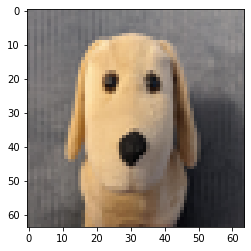

In [92]:
my_image = "nell.jpg"   
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")




#fname = my_image
#image = np.array(Image.open(fname).resize((num_px, num_px)))
#plt.imshow(image)
#image = image / 255.
#image = image.reshape((1, num_px * num_px * 3)).T
#my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

#print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

NameError: name 'logistic_regression_model' is not defined

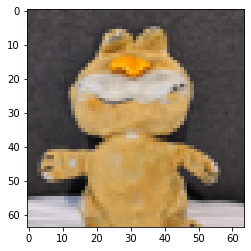

In [ ]:
my_image = "bao.jpg"   

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [ ]:
my_image = "my_image.jpg"   

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")